# Comparing Networks

In this notebook, we want to compare different network to each other.
This one focuses on...

- Generator Machine Unlearning*$^1$

There will be a notebook for every approx. MU algorithm

*$^1$ GEMU: The implemented algorithm is not the same as the one in the paper. While the paper focused on unlearning specific classes, we are training to unlearn a subset of a class, tied together by a feature, which distinguish it from the rest.

### ! Make sure that Trained, Exact, Untrained Model types are trained !

In [41]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
import copy
from PIL import Image
import numpy as np
# from helper import get_model TODO Muss überarbeitet werden
from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet
from training import main, train_n_models
from helper import load_models_dict

USED_DATASET = "cmnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

#########################
ALLREADY_TRAINED = False# <--- The Switch
#########################

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= True,
    test = False,
    dataset_name = USED_DATASET,
    download=True,
)
len(unlearned_data)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'


126

In [42]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

In [43]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    untrained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    untrained_showcase_all = ConvNet()
name = str(untrained_showcase_all)
untrained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained", map_location=DEVICE,
        weights_only=True
        )
    )
untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model


In [44]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    trained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    trained_showcase_all = ConvNet()
name = str(trained_showcase_all)
trained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
        weights_only=True
        )
    )

<All keys matched successfully>

In [45]:
trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Generator Machine Unlearning

In [46]:
from unlearning import unlearn_n_models, GeneratorMachineUnlearning
from training import save_model

In [47]:
# Train a single model first
if not ALLREADY_TRAINED:
    sga = GeneratorMachineUnlearning(
        model=trained_showcase_all,
        dataset_name=USED_DATASET,
    )
    mu_showcase = sga.unlearn(logs=True)
    save_model(mu_showcase, name="mu_showcase", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}GEMU", logs=False)
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        mu_showcase= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        mu_showcase= ConvNet()
    name = str(mu_showcase)
    mu_showcase.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}GEMU{os.sep}{name}_mu_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

Baseline Performance
Time: 0.03769993782043457
Epoch: 1, Loss: 7789.421875
Epoch: 2, Loss: 6517.71533203125
Epoch: 3, Loss: 4900.34619140625
Epoch: 4, Loss: 2532.37451171875
Epoch: 5, Loss: 1792.4200439453125
Epoch: 6, Loss: 1649.7398681640625
Ending NoiseGenerator Maximazation Phase
Time: 0.641077995300293
______
Starting Impairing Phase
Time: 0.6679749488830566
Train loss 1: 64.01492989365825
Ending Impairing Phase
Time: 1.5700149536132812
Train loss 1: 18.335806471960886
Ending Repairing Phase
Time: 2.250035047531128
______


In [48]:
if not ALLREADY_TRAINED:
    mu_ms = unlearn_n_models(
        models=trained_ms,
        unlearned_data=unlearned_data,
        dataset_name=USED_DATASET,
        which_unlearning="GeneratorMachineUnlearning",
        logs=True,
    )
    for i, model in mu_ms.items():
        save_model(model=model, name=f"{i}_mu", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}GEMU{os.sep}test_ensemble", logs=False)

else:
    mu_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}GEMU{os.sep}test_ensemble")

Unlearning 30 models trained on cmnist
Unlearned model  1/30...
Unlearned model  2/30...
Unlearned model  3/30...
Unlearned model  4/30...
Unlearned model  5/30...
Unlearned model  6/30...
Unlearned model  7/30...
Unlearned model  8/30...
Unlearned model  9/30...
Unlearned model 10/30...
Unlearned model 11/30...
Unlearned model 12/30...
Unlearned model 13/30...
Unlearned model 14/30...
Unlearned model 15/30...
Unlearned model 16/30...
Unlearned model 17/30...
Unlearned model 18/30...
Unlearned model 19/30...
Unlearned model 20/30...
Unlearned model 21/30...
Unlearned model 22/30...
Unlearned model 23/30...
Unlearned model 24/30...
Unlearned model 25/30...
Unlearned model 26/30...
Unlearned model 27/30...
Unlearned model 28/30...
Unlearned model 29/30...
Unlearned model 30/30...


___
### Exact Model

In [49]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    exact_showcase = TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    exact_showcase = ConvNet()
name = str(exact_showcase)
exact_showcase.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
        weights_only=True
        )
    )

<All keys matched successfully>

In [50]:
exact_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}test_ensemble")

___

## Metrics

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [51]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Untrained to ...

In [52]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

36.35766925464074

In [53]:
# ...unlearned model
a12 = calc_mutlimodel_metric_average(untrained_ms, mu_ms, metric="l2_norm")
a12

236.91025360226632

In [54]:
# ...exact model
a13 = calc_mutlimodel_metric_average(untrained_ms, exact_ms, metric="l2_norm")
a13

36.356093346575896

#### Trained to ...

In [55]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, mu_ms, metric="l2_norm")
a21

235.33467615644136

In [56]:
# ...exact model
a22 = calc_mutlimodel_metric_average(trained_ms, exact_ms, metric="l2_norm")
a22

38.120168990890186

#### GEMU to ...

In [57]:
# ...exact model
a31 = calc_mutlimodel_metric_average(mu_ms, exact_ms, metric="l2_norm")
a31

238.57461344947419

#### Exact to ...

In [58]:
# see above

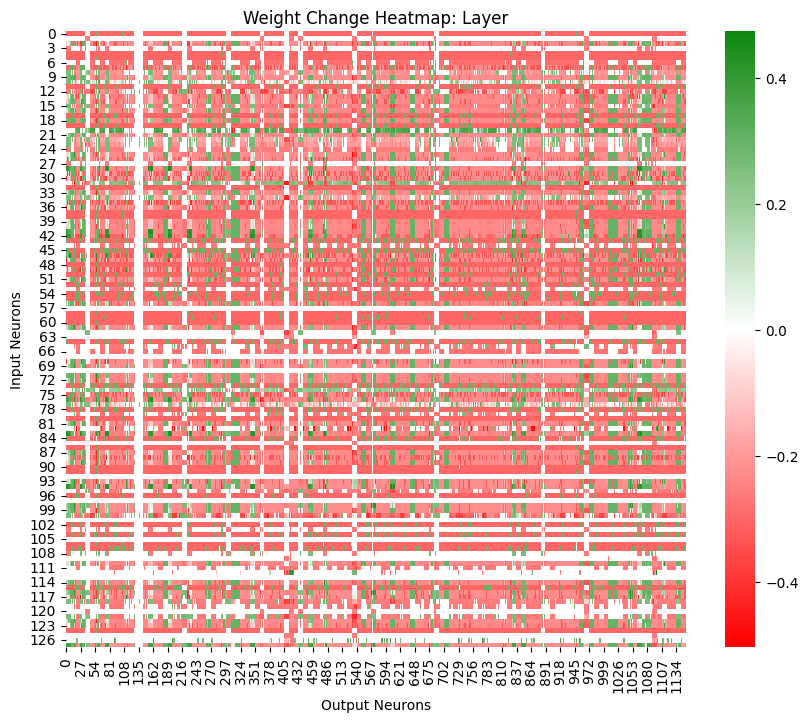

In [59]:
from visualize import visualize_weight_change

visualize_weight_change(weights_before=trained_ms[1].fc1.weight, weights_after=mu_ms[1].fc1.weight)

### Layer-wise Distance

In [60]:
from metrics import model_layer_wise_difference
lw_dist = {}
for t, mu in zip(trained_ms.values(), mu_ms.values()):
    new = model_layer_wise_difference(t, mu)
    if len(lw_dist) == 0:
        for name in new.keys():
            lw_dist[name] = []
    for name in new.keys():
        lw_dist[name].append(new[name])
for key in lw_dist.keys():
    lw_dist[key] = sum(lw_dist[key])/len(lw_dist[key])
lw_dist

{'conv1.weight': 229.3085494995117,
 'conv1.bias': 8.648500601450602,
 'conv2.weight': 5113.28447265625,
 'conv2.bias': 18.64014418919881,
 'conv3.weight': 19352.4373046875,
 'conv3.bias': 46.62340621948242,
 'fc1.weight': 28955.562955729165,
 'fc1.bias': 39.246887588500975,
 'fc2.weight': 311.7699900309245,
 'fc2.bias': 1.1971755842367808}

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [61]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Untrained to...

In [62]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.027651899747312806

#### Trained to...

In [63]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

3.9385107420384884

#### Exact to...

In [64]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

3.251145437111457

#### MU to...

In [65]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.04903658981511399

In [66]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.533318222562472

In [67]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.3231686346232892

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [68]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average accuracy for D_gesamt: 0.1191 - Standard Deviation for D_gesamt: 0.0633


Average accuracy for D_remain: 0.1066 - Standard Deviation for D_remain: 0.0658


Average accuracy for 0: 0.0274 - Standard Deviation for 0: 0.1477


Average accuracy for 1: 0.0256 - Standard Deviation for 1: 0.1377


Average accuracy for 2: 0.0173 - Standard Deviation for 2: 0.0933


Average accuracy for 3: 0.0108 - Standard Deviation for 3: 0.0583


Average accuracy for 4: 0.0230 - Standard Deviation for 4: 0.1236


Average accuracy for 5: 0.0056 - Standard Deviation for 5: 0.0301


Average accuracy for 6: 0.0066 - Standard Deviation for 6: 0.0356


Average accuracy for 8: 0.0086 - Standard Deviation for 8: 0.0462


Average accuracy for 9: 0.0019 - Standard Deviation for 9: 0.0104


Average accuracy for 7_all: 0.9900 - Standard Deviation for 7_all: 0.0540


Average accuracy for 7_remain: 0.9915 - Standard Deviation for 7_remain: 0.0459


Average accuracy for 7_erased: 0.9802 - Standard Deviation for 7_erased: 0.1068
plotting...


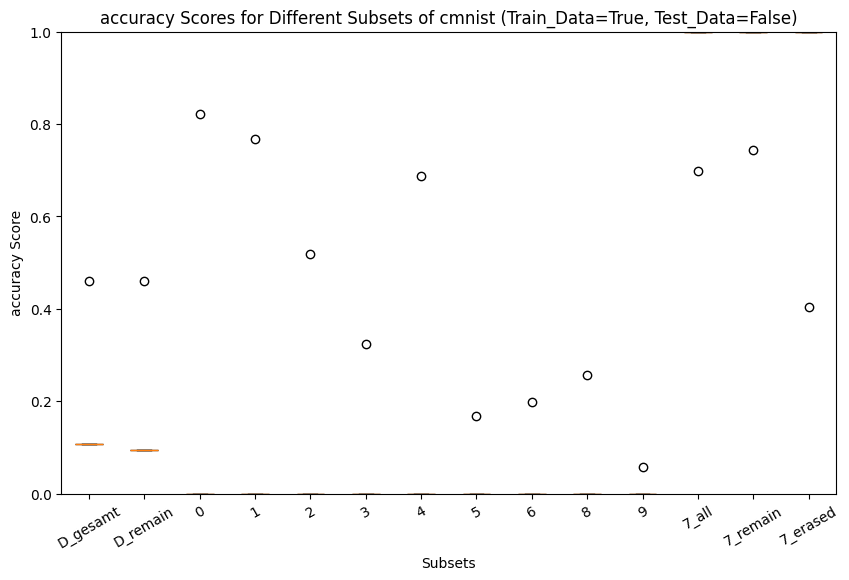

In [69]:
accs["mu_ms_train"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="accuracy", train_split=True, test_split=False, logs=True)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average accuracy for D_gesamt: 0.1150 - Standard Deviation for D_gesamt: 0.0655


Average accuracy for D_remain: 0.1029 - Standard Deviation for D_remain: 0.0680


Average accuracy for 0: 0.0272 - Standard Deviation for 0: 0.1464


Average accuracy for 1: 0.0277 - Standard Deviation for 1: 0.1491


Average accuracy for 2: 0.0177 - Standard Deviation for 2: 0.0951


Average accuracy for 3: 0.0127 - Standard Deviation for 3: 0.0686


Average accuracy for 4: 0.0227 - Standard Deviation for 4: 0.1223


Average accuracy for 5: 0.0064 - Standard Deviation for 5: 0.0346


Average accuracy for 6: 0.0077 - Standard Deviation for 6: 0.0414


Average accuracy for 8: 0.0067 - Standard Deviation for 8: 0.0361


Average accuracy for 9: 0.0016 - Standard Deviation for 9: 0.0085


Average accuracy for 7_all: 0.9892 - Standard Deviation for 7_all: 0.0583


Average accuracy for 7_remain: 0.9908 - Standard Deviation for 7_remain: 0.0494


Average accuracy for 7_erased: 0.9785 - Standard Deviation for 7_erased: 0.1158
plotting...


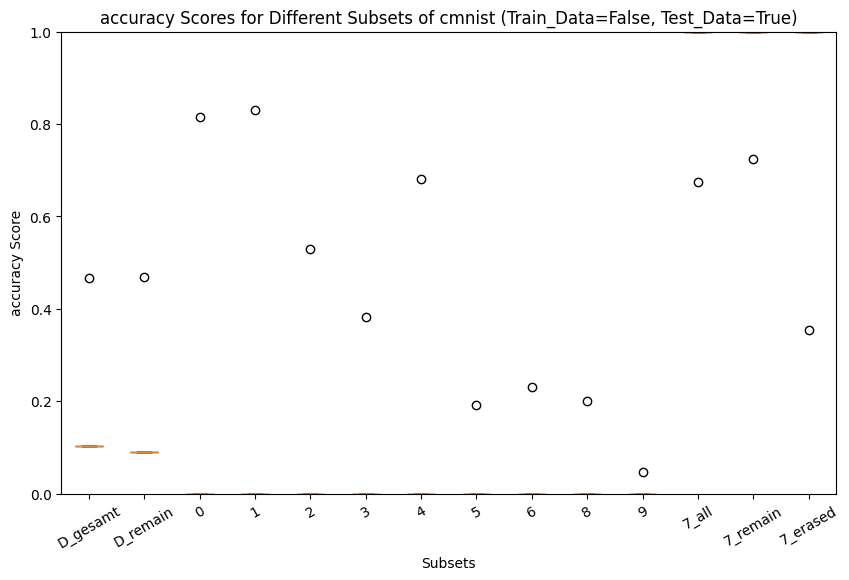

In [70]:
accs["mu_ms_test"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="accuracy", train_split=False, test_split=True, logs=True)

#### Losses

In [71]:
losses = {}

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average loss for D_gesamt: 0.2845 - Standard Deviation for D_gesamt: 0.0185


Average loss for D_remain: 0.2845 - Standard Deviation for D_remain: 0.0186


Average loss for 0: 0.2834 - Standard Deviation for 0: 0.0343


Average loss for 1: 0.2828 - Standard Deviation for 1: 0.0278


Average loss for 2: 0.2861 - Standard Deviation for 2: 0.0230


Average loss for 3: 0.2861 - Standard Deviation for 3: 0.0160


Average loss for 4: 0.2855 - Standard Deviation for 4: 0.0226


Average loss for 5: 0.2872 - Standard Deviation for 5: 0.0109


Average loss for 6: 0.2867 - Standard Deviation for 6: 0.0107


Average loss for 8: 0.2890 - Standard Deviation for 8: 0.0065


Average loss for 9: 0.2885 - Standard Deviation for 9: 0.0039


Average loss for 7_all: 0.2815 - Standard Deviation for 7_all: 0.0264


Average loss for 7_remain: 0.2804 - Standard Deviation for 7_remain: 0.0297


Average loss for 7_erased: 0.2887 - Standard Deviation for 7_erased: 0.0056
plotting...


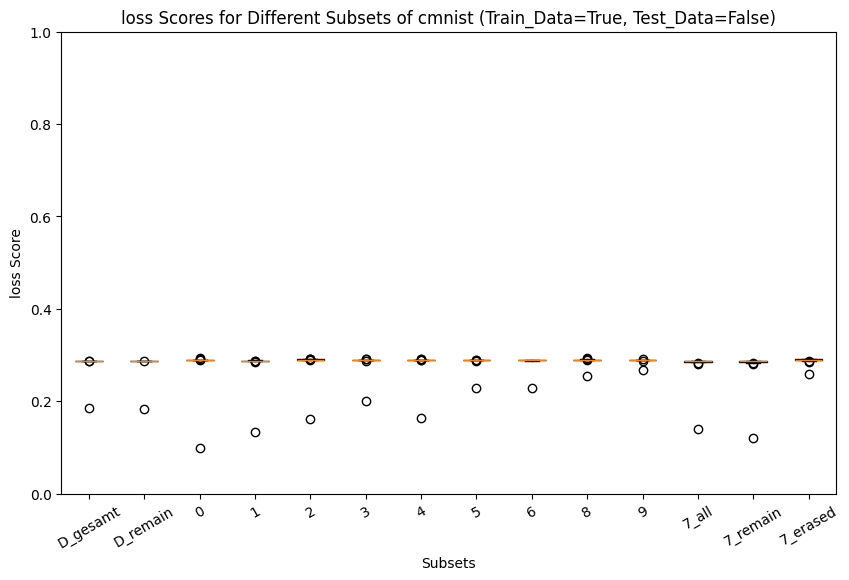

In [72]:
losses["mu_ms_train"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="loss", train_split=True, test_split=False, logs=True)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average loss for D_gesamt: 0.2845 - Standard Deviation for D_gesamt: 0.0182


Average loss for D_remain: 0.2845 - Standard Deviation for D_remain: 0.0185


Average loss for 0: 0.2835 - Standard Deviation for 0: 0.0333


Average loss for 1: 0.2821 - Standard Deviation for 1: 0.0326


Average loss for 2: 0.2840 - Standard Deviation for 2: 0.0236


Average loss for 3: 0.2865 - Standard Deviation for 3: 0.0179


Average loss for 4: 0.2847 - Standard Deviation for 4: 0.0211


Average loss for 5: 0.2870 - Standard Deviation for 5: 0.0109


Average loss for 6: 0.2865 - Standard Deviation for 6: 0.0102


Average loss for 8: 0.2883 - Standard Deviation for 8: 0.0038


Average loss for 9: 0.2900 - Standard Deviation for 9: 0.0015


Average loss for 7_all: 0.2820 - Standard Deviation for 7_all: 0.0230


Average loss for 7_remain: 0.2820 - Standard Deviation for 7_remain: 0.0277


Average loss for 7_erased: 0.2988 - Standard Deviation for 7_erased: 0.0064
plotting...


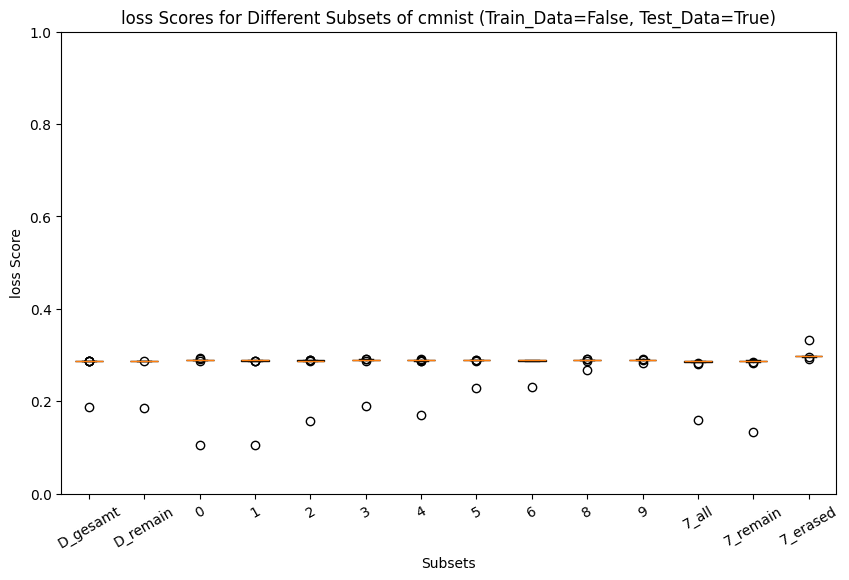

In [73]:
losses["mu_ms_test"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="loss", train_split=False, test_split=True, logs=True)